In [35]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import shap


In [2]:
df = pd.read_csv(r'..\data\onlinedeliverydata.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 55 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        388 non-null    int64  
 1   Gender                                     388 non-null    object 
 2   Marital Status                             388 non-null    object 
 3   Occupation                                 388 non-null    object 
 4   Monthly Income                             388 non-null    object 
 5   Educational Qualifications                 388 non-null    object 
 6   Family size                                388 non-null    int64  
 7   latitude                                   388 non-null    float64
 8   longitude                                  388 non-null    float64
 9   Pin code                                   388 non-null    int64  
 10  Medium (P1)               

In [4]:
drop = [
    'latitude', 'longitude',   
    'Reviews'
]

df_sel = df.drop(columns=drop)

In [5]:
df_sel.shape

(388, 52)

In [6]:
scaler = StandardScaler()
num_cols = df_sel.select_dtypes(include=['int64', 'float64']).columns
df_sel[num_cols] = scaler.fit_transform(df_sel[num_cols])

In [7]:
le = LabelEncoder()
for col in df_sel.select_dtypes(include=['object']).columns:
    df_sel[col] = le.fit_transform(df_sel[col])

In [8]:
X = df_sel.drop('Output', axis=1)
y = df_sel['Output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
rf = RandomForestClassifier(n_estimators=200, random_state=22)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9487179487179487
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.96      0.98      0.97        66

    accuracy                           0.95        78
   macro avg       0.93      0.87      0.89        78
weighted avg       0.95      0.95      0.95        78



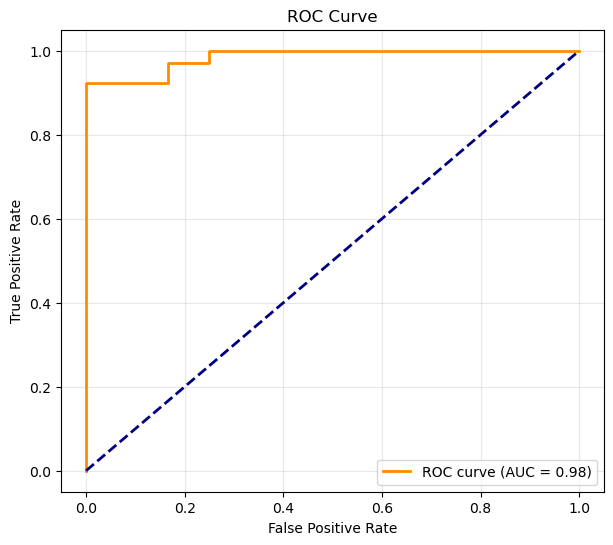

In [10]:
y_pred_proba = rf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [11]:
gb = GradientBoostingClassifier(random_state=22)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting Accuracy: 0.9358974358974359
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.96      0.97      0.96        66

    accuracy                           0.94        78
   macro avg       0.89      0.86      0.87        78
weighted avg       0.93      0.94      0.93        78



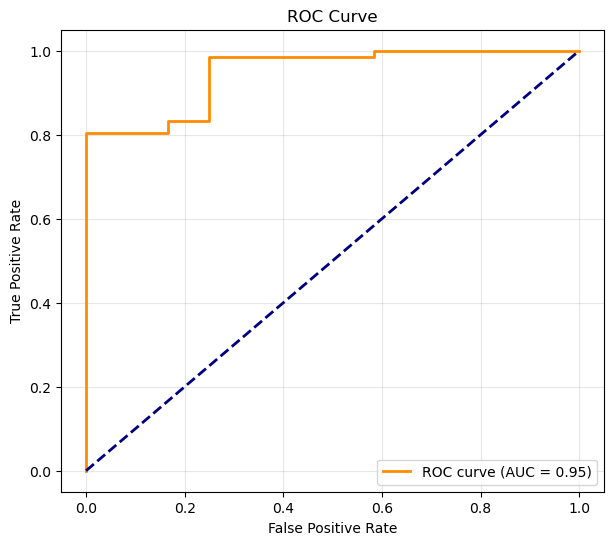

In [12]:
y_pred_proba = gb.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

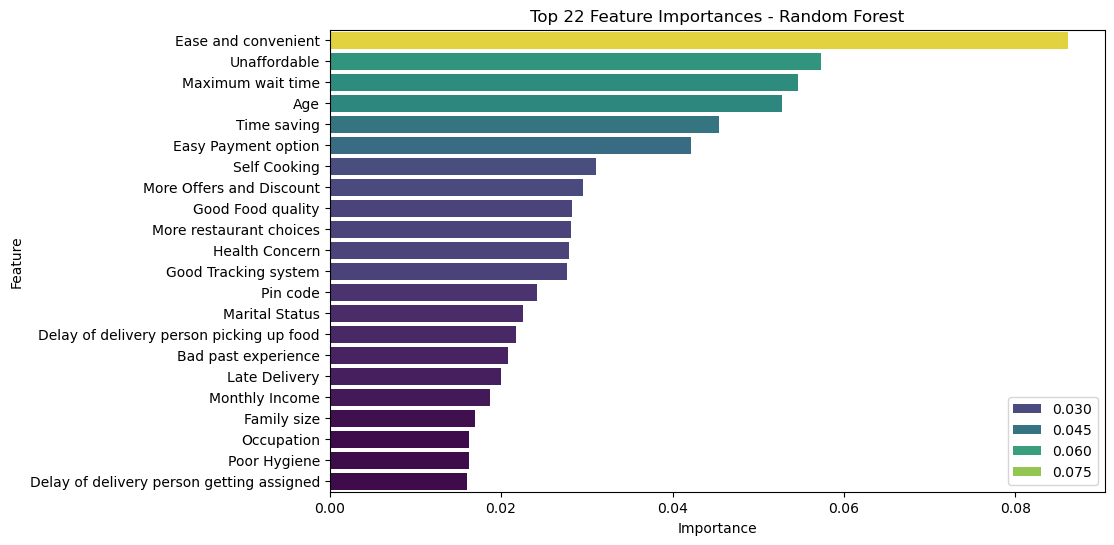

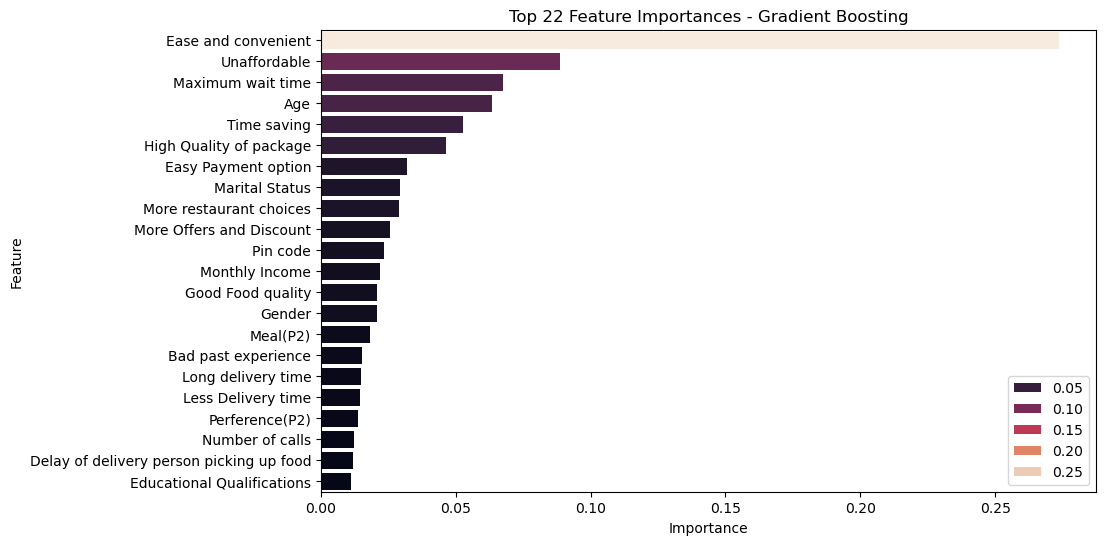

In [13]:
rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
gb_importance = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importance.values[:22], y=rf_importance.index[:22], hue=rf_importance.values[:22], palette="viridis")
plt.title("Top 22 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=gb_importance.values[:22], y=gb_importance.index[:22],hue=gb_importance.values[:22], palette="rocket")
plt.title("Top 22 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [30]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

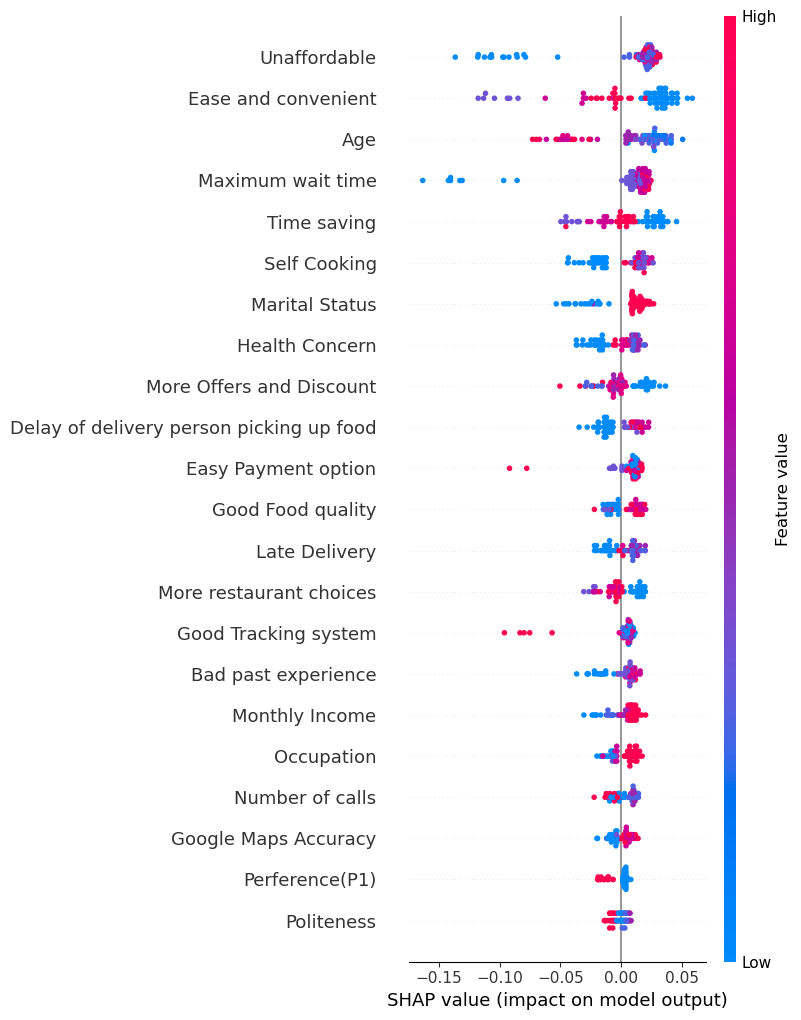

In [25]:
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=22)

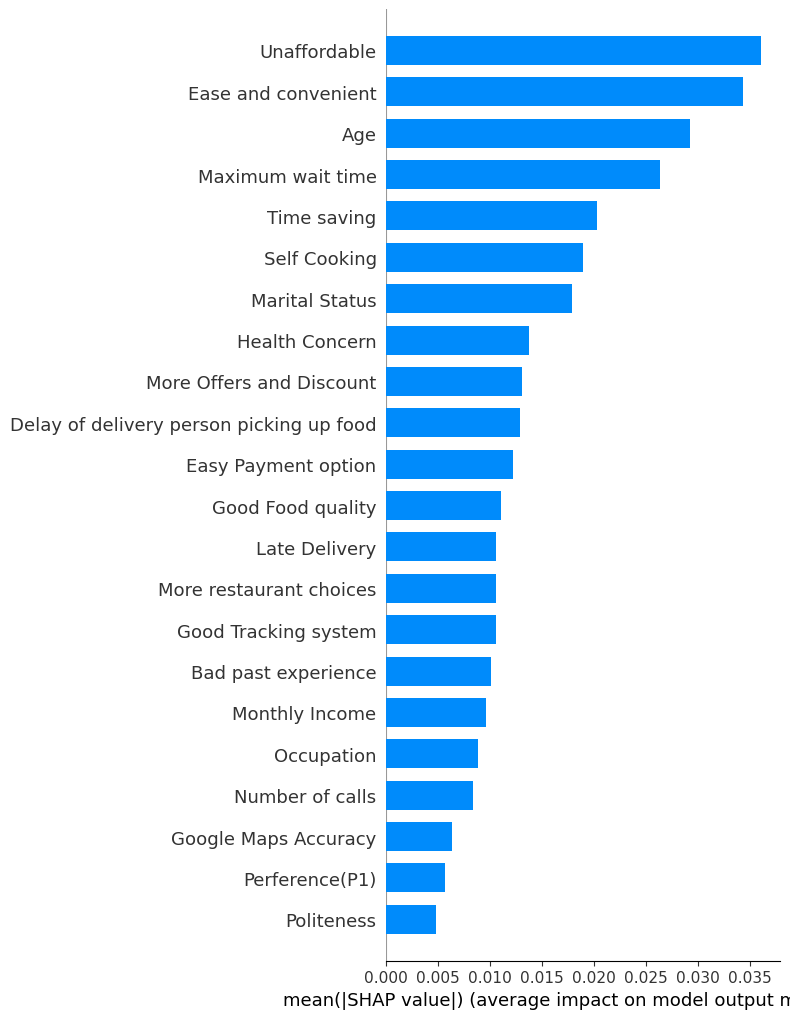

In [28]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=22)

In [31]:
sample_index = 22  
sample = X_test.iloc[sample_index]

 Waterfall for sample 2


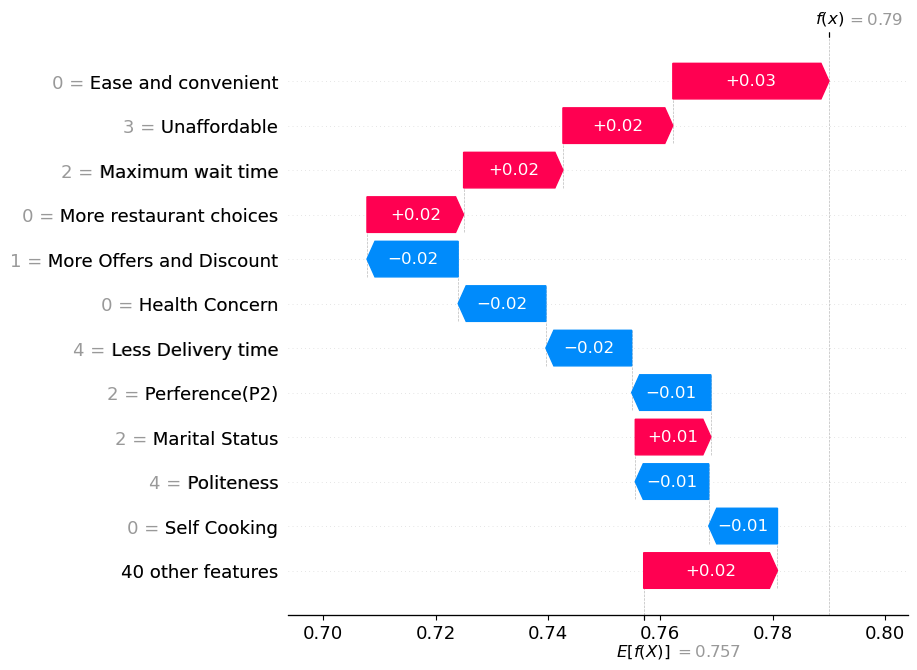

 Waterfall for sample 22


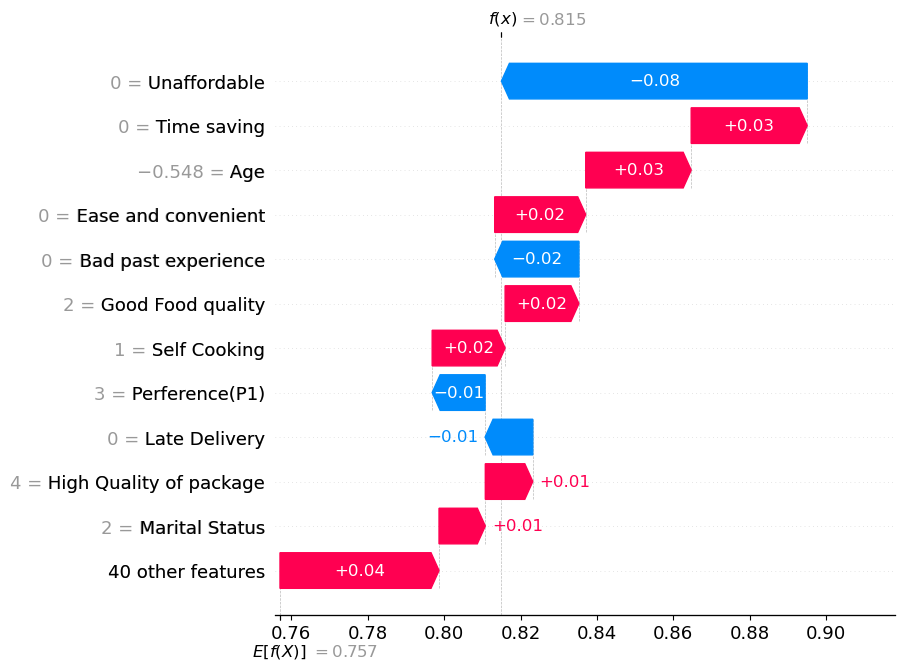

 Waterfall for sample 77


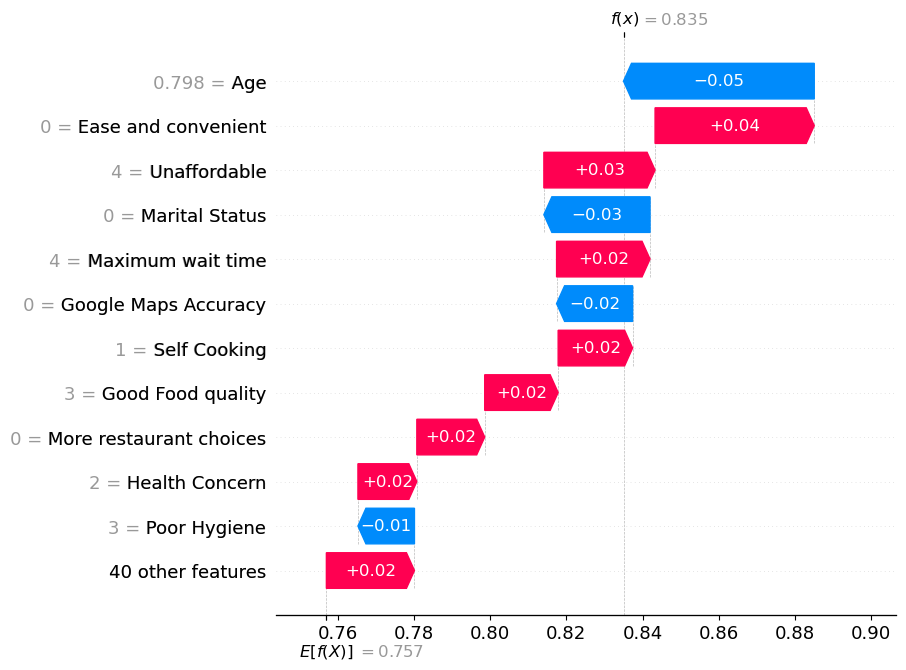

In [33]:
for i in [2, 22, 77]:
    print(f" Waterfall for sample {i}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[:, :, 1][i],
            base_values=explainer.expected_value[1],
            data=X_test.iloc[i],
            feature_names=X_test.columns
        ),
        max_display=12
    )